# Wildfires dataset cleaning

WRITE THE CLEANING OVERVIEW HERE

In [36]:
# Libraries import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
from datetime import timedelta

### Reading data

In [2]:
# Reading the source data 
df = pd.read_csv('../../data/raw/WFIGS_-_Wildland_Fire_Locations_Full_History (3).csv', low_memory=False)

In [3]:
# Checking table
df.head(3)

,X,Y,OBJECTID,ABCDMisc,ADSPermissionState,CalculatedAcres,ContainmentDateTime,ControlDateTime,DailyAcres,DiscoveryAcres,...,IsDispatchComplete,OrganizationalAssessment,StrategicDecisionPublishDate,CreatedOnDateTime_dt,ModifiedOnDateTime_dt,Source,GlobalID,IsCpxChild,CpxName,CpxID
0,-111.414812,40.072836,7,NaN,DEFAULT,NaN,2019/10/31 16:30:00+00,2019/11/05 18:30:00+00,170.0,0.1,...,0,Type 4 Incident,NaN,2019/10/27 00:14:29+00,2019/11/13 00:15:39+00,IRWIN,{BFD53772-94E7-43F0-9D2C-62444A07CA68},NaN,NaN,NaN
1,-112.439311,34.403275,13,NaN,DEFAULT,NaN,2019/09/09 17:00:00+00,2019/09/09 17:00:00+00,0.1,0.5,...,0,NaN,NaN,2019/09/05 20:14:11+00,2019/09/14 19:28:38+00,IRWIN,{E656CA4D-EECE-4746-AEE3-4D645C4F1F13},NaN,NaN,NaN
2,-108.895411,40.239896,31,NaN,DEFAULT,NaN,2019/07/30 18:00:00+00,2019/08/03 14:00:00+00,90.0,1.0,...,0,NaN,NaN,2019/07/28 22:52:13+00,2019/08/10 18:31:55+00,IRWIN,{50C0D06E-E3DC-4094-BF22-B9D4B7BA68B1},NaN,NaN,NaN


### Datatime conversion

In [4]:
# Converting datetime columns to a proper datetime format
df['FireDiscoveryDateTime'] = pd.to_datetime(df['FireDiscoveryDateTime'])
df['ContainmentDateTime'] = pd.to_datetime(df['ContainmentDateTime'])
df['ControlDateTime'] = pd.to_datetime(df['ControlDateTime'])

In [5]:
# We've decided to focus on only wildfires (marked as WF in the source table) which happened in 2020 or later
df = df[df['FireDiscoveryDateTime']>='2020-01-01']
df = df[df['IncidentTypeCategory'] == 'WF']

In [6]:
# Checking dimensions
df.shape

(22799, 96)

In [7]:
# Sorting fires by the start date for the future convenience
df.sort_values('FireDiscoveryDateTime')
df.reset_index(drop = True, inplace = True)

### Removing missing values

In [8]:
# Checking missing values
df.isnull().sum()

X                         0
Y                         0
OBJECTID                  0
ABCDMisc              19795
ADSPermissionState        0
                      ...  
Source                    0
GlobalID                  0
IsCpxChild            12715
CpxName               22745
CpxID                 22745
Length: 96, dtype: int64

In [9]:
df['ContainmentDateTime'].isnull().sum()

325

In [10]:
df['DailyAcres'].isnull().sum()

223

In [11]:
# Removing fires for which there's no acreage and containment date
df = df[df['DailyAcres'].isnull() == False]
df = df[df['ContainmentDateTime'].isnull() == False]

In [12]:
# Checking dimensions
df.shape

(22251, 96)

In [13]:
# Removing columns we're not going to use
df = df[['X', 'Y', 'ContainmentDateTime', 'ControlDateTime', 'DailyAcres',
       'DiscoveryAcres', 'FireCause', 'FireDiscoveryDateTime',
       'IncidentTypeCategory', 'IncidentTypeKind', 'InitialLatitude',
       'InitialLongitude', 'IrwinID', 'LocalIncidentIdentifier', 'POOCounty',
       'POODispatchCenterID', 'POOFips', 'POOState', 'UniqueFireIdentifier']].copy()

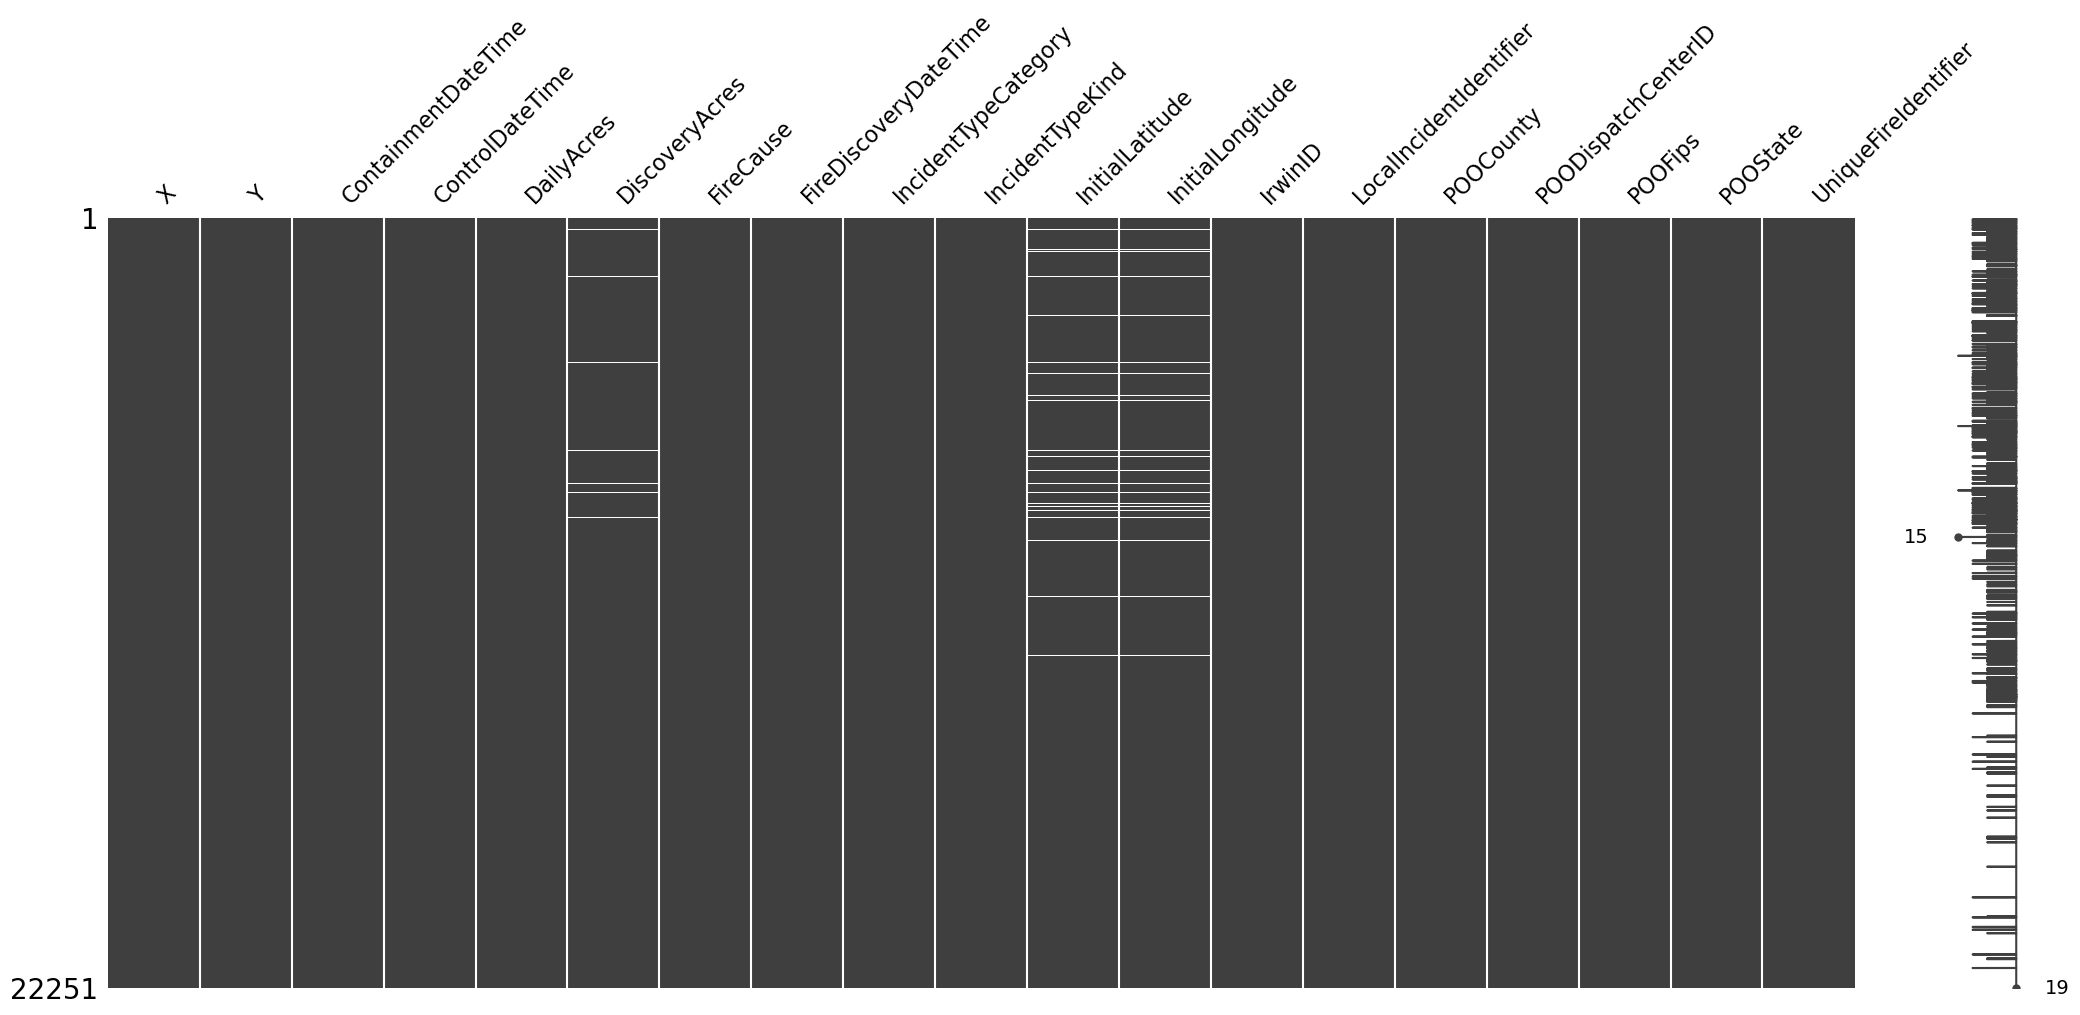

In [14]:
# Visualising missing values with missingno library
msno.matrix(df);

In [15]:
df.isnull().sum()

X                            0
Y                            0
ContainmentDateTime          0
ControlDateTime              0
DailyAcres                   0
DiscoveryAcres             196
FireCause                   12
FireDiscoveryDateTime        0
IncidentTypeCategory         0
IncidentTypeKind             0
InitialLatitude            709
InitialLongitude           709
IrwinID                      0
LocalIncidentIdentifier      0
POOCounty                    0
POODispatchCenterID          0
POOFips                      0
POOState                     0
UniqueFireIdentifier         0
dtype: int64

In [16]:
# Another iteration of dropping missing values
df = df.dropna()

In [17]:
# Checking dimensions
df.shape

(21541, 19)

In [18]:
# Checking data types
df.dtypes

X                                      float64
Y                                      float64
ContainmentDateTime        datetime64[ns, UTC]
ControlDateTime            datetime64[ns, UTC]
DailyAcres                             float64
DiscoveryAcres                         float64
FireCause                               object
FireDiscoveryDateTime      datetime64[ns, UTC]
IncidentTypeCategory                    object
IncidentTypeKind                        object
InitialLatitude                        float64
InitialLongitude                       float64
IrwinID                                 object
LocalIncidentIdentifier                 object
POOCounty                               object
POODispatchCenterID                     object
POOFips                                 object
POOState                                object
UniqueFireIdentifier                    object
dtype: object

### Calculating total acreage burned

In [19]:
# Creating a total acreage column which is a sum of DiscoveryAcres and DailyAcres
df['total_acres'] = df['DiscoveryAcres'] + df['DailyAcres']

### Removing observations with incorrect coordinates

Some of the fire start locations were typed in incorrectly, so we had to get rid of them.

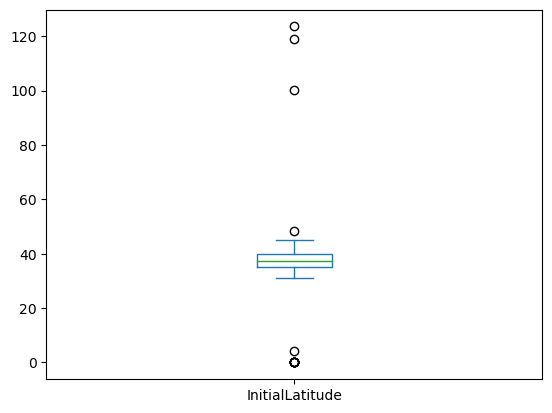

In [20]:
# Latitude outliers
df.InitialLatitude.plot(kind = 'box');

In [21]:
df.InitialLatitude.describe()

count    21541.000000
mean        37.460073
std          2.991221
min          0.000000
25%         35.014580
50%         37.474110
75%         39.729390
max        123.550107
Name: InitialLatitude, dtype: float64

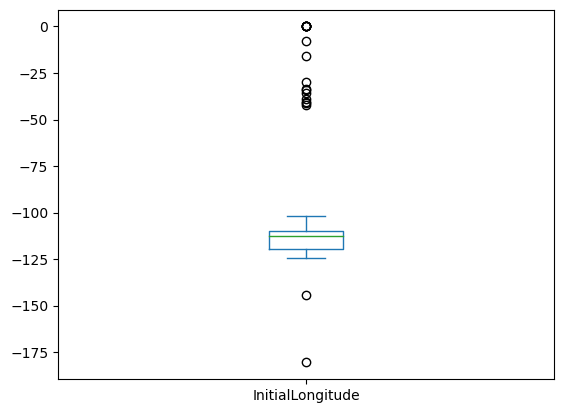

In [22]:
# Longitude outliers
df.InitialLongitude.plot(kind = 'box');

In [23]:
df.InitialLongitude.describe()

count    21541.000000
mean      -113.820538
std          5.952522
min       -180.540000
25%       -119.634700
50%       -112.385000
75%       -109.709900
max          0.000000
Name: InitialLongitude, dtype: float64

In [24]:
# Checking how many observations have incorrect coordinates
df[(df['InitialLongitude'] > -100) | (df['InitialLongitude'] < -125) | (df['InitialLatitude'] > 45) | (df['InitialLatitude'] < 30)].shape

(24, 20)

In [25]:
# Getting rid of observations with incorrect coordinates
df = df[~((df['InitialLongitude'] > -100) | (df['InitialLongitude'] < -125) | (df['InitialLatitude'] > 45) | (df['InitialLatitude'] < 30))] # tilda inverses DataFrame filter

In [26]:
# Checking dimensions
df.shape

(21517, 20)

### Creating fire id column

In [27]:
# Creating fire_id column from index
df['fire_id'] = df.index.copy()

In [29]:
# Looking at final table
df.head(3)

,X,Y,ContainmentDateTime,ControlDateTime,DailyAcres,DiscoveryAcres,FireCause,FireDiscoveryDateTime,IncidentTypeCategory,IncidentTypeKind,...,InitialLongitude,IrwinID,LocalIncidentIdentifier,POOCounty,POODispatchCenterID,POOFips,POOState,UniqueFireIdentifier,total_acres,fire_id
0,-111.348611,33.195755,2020-07-23 05:29:59+00:00,2020-07-23 05:29:59+00:00,8.0,2.5,Human,2020-07-22 21:51:00+00:00,WF,FI,...,-111.348700,{951823FA-0B72-4295-87C8-E042D602324E},001450,Pinal,AZTDC,04021,US-AZ,2020-AZA3S-001450,10.5,0
1,-115.748812,40.617506,2020-08-03 23:00:00+00:00,2020-09-02 15:00:00+00:00,5985.9,5.0,Natural,2020-07-19 23:00:00+00:00,WF,FI,...,-115.719777,{91E0CBAB-A24E-4590-B6C6-2B4A46907E8A},010145,Elko,NVEIC,32007,US-NV,2020-NVECFX-010145,5990.9,1
3,-108.193611,39.858486,2020-08-30 00:00:00+00:00,2020-09-10 14:00:00+00:00,0.1,1.0,Natural,2020-08-29 21:46:00+00:00,WF,FI,...,-108.266500,{3568D344-E3FB-415C-8014-ED34ECEAAB25},000323,Rio Blanco,COCRC,08103,US-CO,2020-COWRD-000323,1.1,3


In [30]:
df.shape

(21517, 21)

In [32]:
# Saving all fires
df.to_csv('../../data/cleaned/wildfires_all.csv', index = False)

### Filtered fires dataset
During modeling, we realized that it's quite hard to predict acreage for all files in this dataset, because there are a lot of small fires which were contained within the first day. We've decided to remove them and focus on only those fires that went beyond tiny incidents.

In [33]:
df.shape

(21517, 21)

In [34]:
# Querying only fires with acreage more than 1 acre and controlled later than within the day from fire discovery.
# Acreage
filtered_df = (df[df['DailyAcres'] > 1]) 
filtered_df.shape

(4281, 21)

In [37]:
# Control date
filtered_df = filtered_df[((filtered_df['ControlDateTime'] - filtered_df['FireDiscoveryDateTime']) > timedelta(days=1))]
filtered_df.shape

(2854, 21)

In [38]:
# Saving result to another table
filtered_df.to_csv('../../data/cleaned/wildfires_filtered.csv', index = False)